In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccovf
from scipy import signal

In [2]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

In [3]:
%%time 
t0=0
T=1000
dt=0.1

phi=45

N=180
Ne=180
Ni=180

tau_E=20
tau_I=10
tau_n=1

c_ne=10
c_ni=10

J_EE=0.044
J_II=-0.018
J_EI=-0.023
J_IE=0.042

sigma_ori=32
sigma_FF=30

k=0.04
n=2.0

c=50



r_E = np.zeros((Ne,1)) # firing rate vector of E neurons
r_I = np.zeros((Ni,1)) # firing rate vector of I neurons
zero = np.zeros((N,1)) # Nx1 zero vector
xs = np.linspace(0, 179, 180)

xe = np.zeros((Ne,1))
xi = np.zeros((Ni,1))

R_E = r_E # these will store firing rates at each timestep as columns
R_I = r_I 

G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # connectivity matrix G
h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
h = h[:,None] # makes shape (180,1)
W_EE = J_EE*G_ori
W_EI = J_EI*G_ori
W_IE = J_IE*G_ori
W_II = J_II*G_ori


I_E = c*h + W_EE@r_E + W_EI@r_I # initial inputs 
I_I = c*h + W_IE@r_E + W_II@r_I
rE_SS = k*(np.power(np.maximum(I_E, zero), n)) # initial steady state rates
rI_SS = k*(np.power(np.maximum(I_I, zero), n))

M = int(T/dt)
ts = np.arange(M+1)

r_exc = []
r_inh = []

for m in range(M):
    n_e = np.random.randn(Ne,1)
    n_i = np.random.randn(Ni,1)

    xe = xe + (1/tau_n)*(-xe*dt + np.sqrt(2*tau_n*dt)*n_e)
    xi = xi + (1/tau_n)*(-xi*dt + np.sqrt(2*tau_n*dt)*n_i)

    r_E = r_E + dt*(1/tau_E)*(-r_E + rE_SS)
    r_I = r_I + dt*(1/tau_I)*(-r_I + rI_SS)

    I_E = c*h + W_EE@r_E + W_EI@r_I + c_ne*xe
    I_I = c*h + W_IE@r_E + W_II@r_I + c_ni*xi

    rE_SS = k*(np.power((np.maximum(I_E, zero)), n))
    rI_SS = k*(np.power((np.maximum(I_I, zero)), n))
    R_E = np.c_[R_E, r_E]
    R_I = np.c_[R_I, r_I]

CPU times: user 1min 12s, sys: 27.2 s, total: 1min 39s
Wall time: 18.4 s


In [4]:
def xcov(x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    return signal.convolve(x-xbar, y[::-1]-ybar, mode='full')

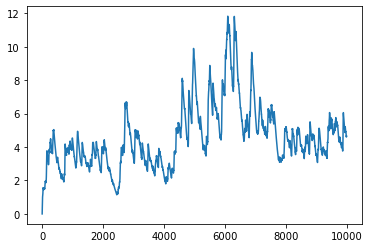

In [11]:
plt.plot(R_E[0,:])
plt.show()

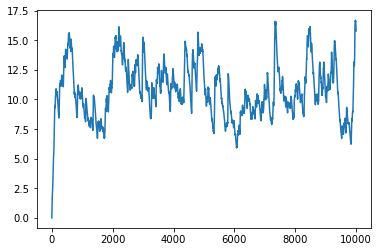

In [12]:
plt.plot(R_E[12,:])

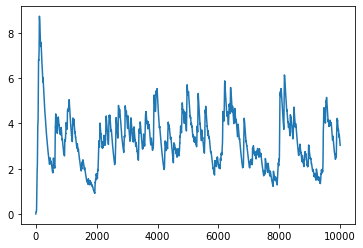

In [14]:
plt.plot(R_E[174,:])
plt.show()

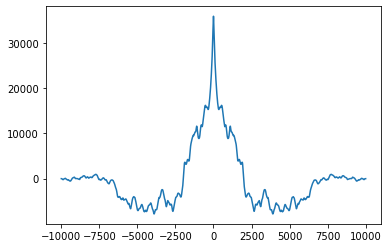

In [5]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[0,:], R_E[0,:]))
plt.show()

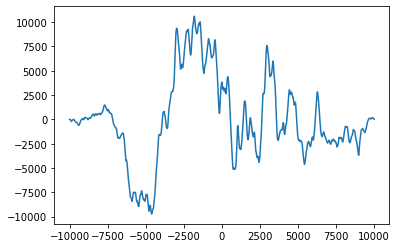

In [6]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[1,:], R_E[0,:]))
plt.show()

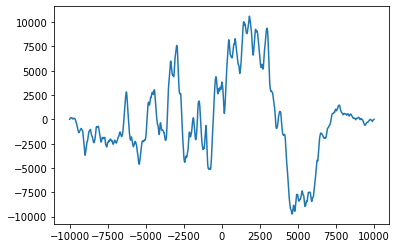

In [7]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[0,:], R_E[1,:]))
plt.show()

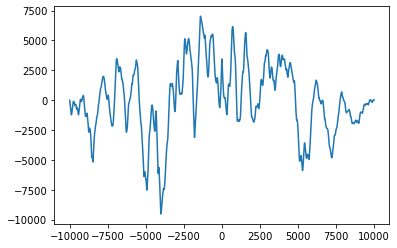

In [8]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[23,:], R_E[163,:]))
plt.show()

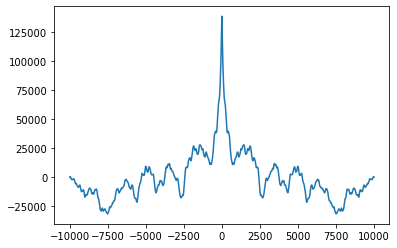

In [9]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[23,:], R_E[23,:]))
plt.show()

In [10]:
np.trapz(xcov(R_E[0,:], R_E[1,:]))

0.16505270381458104

In [11]:
np.trapz(xcov(R_E[23,:], R_E[0,:]))

-24.683208201779053

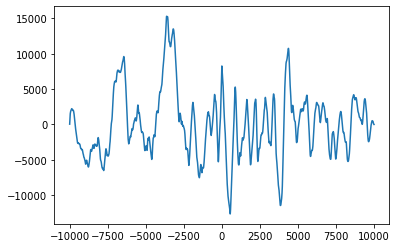

In [12]:
plt.plot(np.arange(-R_E[0,:].shape[0]+1, R_E[0,:].shape[0]), xcov(R_E[23,:], R_E[0,:]))
plt.show()

In [ ]:
signal.convolve2d(R_E-R_E.mean(axis=1, keepdims=True), np.flip(R_E,axis=1)-R_E.mean(axis=1, keepdims=True), mode='full')

In [17]:
np.flip(R_E, axis=1)

array([[2.29544894, 2.19945985, 2.11423907, ..., 0.09161834, 0.05269961,
        0.        ],
       [6.32000151, 6.33667518, 6.34219878, ..., 0.10576539, 0.0581774 ,
        0.        ],
       [4.84258206, 4.86691665, 4.89137351, ..., 0.19851048, 0.06408201,
        0.        ],
       ...,
       [5.28260998, 5.30915576, 5.33583493, ..., 0.07742537, 0.03865237,
        0.        ],
       [2.53121648, 2.54393616, 2.55318918, ..., 0.05677572, 0.04295546,
        0.        ],
       [4.91097071, 4.93564896, 4.96045122, ..., 0.090022  , 0.04763163,
        0.        ]])